In [1]:
import numpy as np
import pandas as pd
from numpy import linalg as nplin
# import volpriceinference as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool

In [2]:
import volprice as vl

In [3]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [4]:
logging.basicConfig(filename='convergence.tmp.log', level=logging.INFO)
logging.captureWarnings(True)

## Setup the True Parameters /  Simulation Parameters

In [5]:
true_params = {'equity_price': 0.50, 
               'vol_price': -7,
               'zeta': 1 - .2**2,
               'scale': .1,
               'delta': 1.11,
               'rho': .6,
              }
time_dim = 3000
sim_dim = 1000

## Setup the linking functions.

In [6]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(rho=true_params['rho'], scale=true_params['scale'], delta=true_params['delta'], 
                       zeta=true_params['zeta'], pi=true_params['vol_price'], theta=true_params['equity_price']),
     'beta':vl.compute_beta(rho=true_params['rho'], scale=true_params['scale'], zeta=true_params['zeta'], 
                    pi=true_params['vol_price'], theta=true_params['equity_price']),
     'psi':vl.compute_psi(rho=true_params['rho'], scale=true_params['scale'], zeta=true_params['zeta'], 
                  theta=true_params['equity_price'])})

## We start by examining the distributions of simulated data

In [7]:
vl.__version__

AttributeError: module 'volprice' has no attribute '__version__'

In [9]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

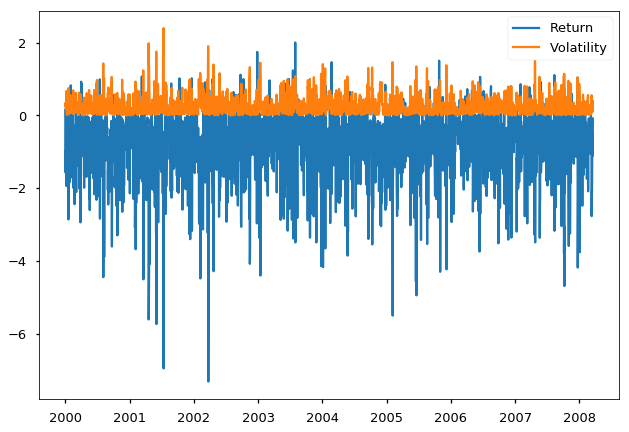

In [10]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return')
ax1.plot(data.vol, label='Volatility')
ax1.legend()


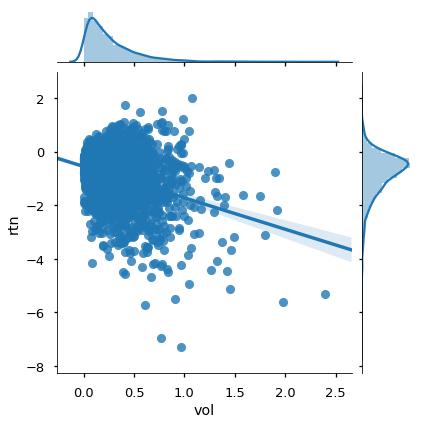

In [11]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [12]:
data.describe()

,vol,rtn
count,3000.000000,3000.000000
mean,0.262305,-0.862875
std,0.248743,0.874185
min,0.000143,-7.309801
25%,0.087534,-1.269016
50%,0.188204,-0.684727
75%,0.364417,-0.316381
max,2.393852,1.999885


## The Asymptotic Distributions in the Strongly Identified Case

In [13]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [14]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(vl.estimate_params, data_arr), total=len(data_arr)))

Text(0.5,0,'delta')

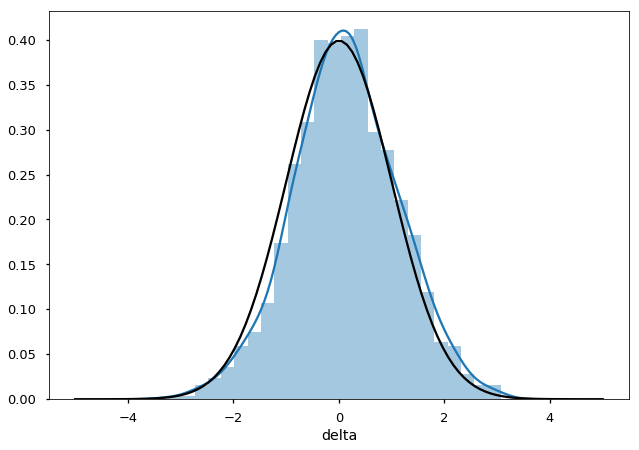

In [15]:
delta_fig, delta_ax = mpl.pyplot.subplots()
sns.distplot([(est['delta'] - true_params['delta']) / np.sqrt(cov.loc['delta','delta']) 
              for est, cov in est_arr], ax=delta_ax)
delta_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
delta_ax.set_xlabel('delta')

Text(0.5,0,'scale')

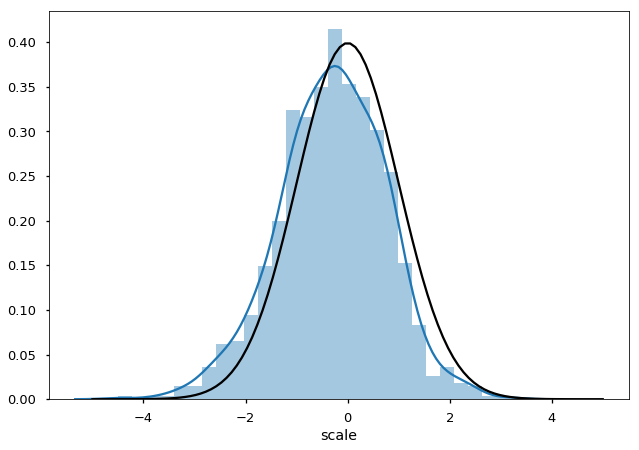

In [16]:
scale_fig, scale_ax = mpl.pyplot.subplots()
sns.distplot([(est['scale'] - true_params['scale']) / np.sqrt(cov.loc['scale', 'scale']) 
              for est, cov in est_arr], ax=scale_ax)
scale_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
scale_ax.set_xlabel('scale')

Text(0.5,0,'rho')

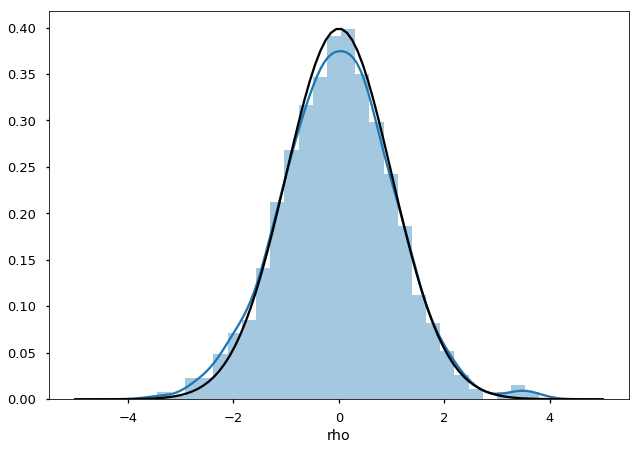

In [17]:
rho_fig, rho_ax = mpl.pyplot.subplots()
sns.distplot([(est['rho'] - true_params['rho']) / np.sqrt(cov.loc['rho', 'rho']) 
              for est, cov in est_arr], ax=rho_ax)
rho_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
rho_ax.set_xlabel('rho')

In [18]:
# equity_price_fix, equity_price_ax = mpl.pyplot.subplots()
# sns.distplot([(est['equity_price'] - true_params['equity_price']) / 
#               np.sqrt(cov.loc['equity_price', 'equity_price']) for est, cov in est_arr], ax=equity_price_ax)
# equity_price_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
# equity_price_ax.set_xlabel('equity price')

In [19]:
# vol_price_fix, vol_price_ax = mpl.pyplot.subplots()
# sns.distplot([(est['vol_price'] - true_params['vol_price']) / 
#               np.sqrt(cov.loc['vol_price', 'vol_price']) for est, cov in est_arr], ax=vol_price_ax)
# vol_price_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
# vol_price_ax.set_xlabel('vol_price')

(-10, 10)

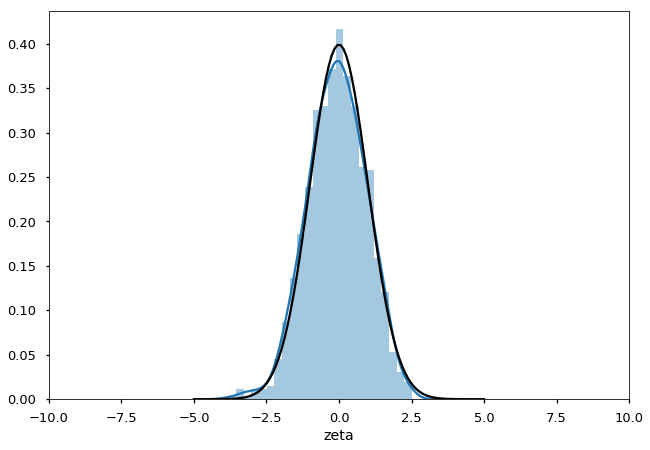

In [20]:
phi_fig, phi_ax = mpl.pyplot.subplots()
sns.distplot([(est['zeta'] - true_params['zeta']) / np.sqrt(cov.loc['zeta', 'zeta'])
              for est, cov in est_arr], ax=phi_ax)
phi_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
phi_ax.set_xlabel('zeta')
phi_ax.set_xlim([-10,10])

In [21]:
from itertools import product

In [22]:
omega, omega_cov = est_arr[0]

In [23]:
omega_cov

,beta,delta,gamma,psi,rho,scale,zeta
beta,0.000914,0.000000,-0.000106,-0.000528,0.000000,0.000000,0.00000
delta,0.000000,0.002053,0.000000,0.000000,-0.000463,-0.000063,0.00000
gamma,-0.000106,0.000000,0.000031,-0.000007,0.000000,0.000000,0.00000
psi,-0.000528,0.000000,-0.000007,0.001722,0.000000,0.000000,0.00000
rho,0.000000,-0.000463,0.000000,0.000000,0.000349,-0.000011,0.00000
scale,0.000000,-0.000063,0.000000,0.000000,-0.000011,0.000011,0.00000
zeta,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00063


In [40]:
qlr_stats = pd.DataFrame.from_records([(x[0], x[1], vl.qlr_stat(
    omega=omega,true_prices={'vol':x[0], 'equity':x[1]}, omega_cov=omega_cov))
                                       for x in product(np.linspace(-20, 0, 4), np.linspace(0,1, 5))],
                                      columns=['vol', 'equity', 'qlr'])

In [41]:
qlr_stats.pivot(index='vol', columns='equity',values='qlr')

equity,0.0,0.25,0.5,0.75,1.0
vol,,,,,
-20.000000,25836.062409,25835.616565,25834.711411,25833.803160,25832.435224
-13.333333,24796.585374,24791.353902,24786.100591,24800.611840,24795.314764
-6.666667,19386.209177,19070.928217,18738.460571,18389.078812,18022.666844
0.000000,1033.557293,1088.924253,1165.942760,1244.758209,1325.305110


In [42]:
qlr_draws = pd.DataFrame([([val] + [vl.qlr_sim(omega=true_params, vol_price_true=val, reduced_form_cov=omega_cov, time_dim=data.shape[0])
                                   for _ in tqdm.tqdm_notebook(range(500), leave=False)])
                         for val in np.linspace(-20, 0, 50)])

TypeError: qlr_sim() got an unexpected keyword argument 'vol_price_true'

In [ ]:
qlr_percentiles = pd.DataFrame([(name, val[0], val[1]) for name, val in qlr_draws.set_index(0).agg(
    np.percentile, axis=1, q=[5, 95]).items()]).rename(columns={1:'five',2:'ninety5'})

In [ ]:
accepted_vals = pd.Series(pd.merge(qlr_percentiles, qlr_stats, left_on=0, right_on=0).set_index(0).query('five < stats and ninety5 > stats').index)


In [ ]:
ci_values = pd.concat([pd.Series(qlr_percentiles.set_index(0).query('five < @row').query('ninety5 > @row').index, name=name).to_frame().unstack().reset_index(
    level=0).rename(columns={'level_0':'pi0', 0:'ci'})
          for name, row in qlr_stats.itertuples()])

In [ ]:
min_max_values = ci_values.groupby('pi0').aggregate([np.min, np.mean, np.max]).T.reset_index(0, drop=True).T

In [ ]:
fig2, ax2 = mpl.pyplot.subplots()
# ax2.scatter()
ax2.fill_between(min_max_values.index, min_max_values.amin, min_max_values.amax)

In [ ]:
from matplotlib import ticker as mticker

In [ ]:
np.unique(ci_values.query('pi0<-18').pi0)[::2]

In [ ]:
from itertools import islice

In [ ]:
ax3.xaxis.get_ticklocs()

In [ ]:
fig3, ax3 = mpl.pyplot.subplots()
sns.swarmplot(x='pi0', y='ci', data=ci_values, ax=ax3)
labels_old = ax3.xaxis.get_ticklabels().copy()
ax3.xaxis.set_major_locator(mticker.FixedLocator(ax3.xaxis.get_ticklocs()[::4]))
ax3.xaxis.set_ticklabels(labels_old[::4])
ax3.xaxis.set_major_formatter(mticker.FixedFormatter(["{:.01f}".format(float(val.get_text())) for val in ax3.xaxis.get_ticklabels()]))